# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Cargar-la-intensidad-con-P1-y-P4" data-toc-modified-id="Cargar-la-intensidad-con-P1-y-P4-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargar la intensidad con P1 y P4</a></div><div class="lev2 toc-item"><a href="#Fitting-data-to-sine" data-toc-modified-id="Fitting-data-to-sine-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting data to sine</a></div><div class="lev2 toc-item"><a href="#Calibration-parameters" data-toc-modified-id="Calibration-parameters-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calibration parameters</a></div><div class="lev1 toc-item"><a href="#Otros-ajustes" data-toc-modified-id="Otros-ajustes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Otros ajustes</a></div><div class="lev2 toc-item"><a href="#Fitting-to-matrices---1:-sencillo" data-toc-modified-id="Fitting-to-matrices---1:-sencillo-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fitting to matrices - 1: sencillo</a></div><div class="lev2 toc-item"><a href="#Ajuste-global:-p0,-p1,-angulo" data-toc-modified-id="Ajuste-global:-p0,-p1,-angulo-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ajuste global: p0, p1, angulo</a></div><div class="lev3 toc-item"><a href="#Verificación" data-toc-modified-id="Verificación-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Verificación</a></div><div class="lev3 toc-item"><a href="#Comparación" data-toc-modified-id="Comparación-222"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Comparación</a></div><div class="lev3 toc-item"><a href="#Conclusión" data-toc-modified-id="Conclusión-223"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Conclusión</a></div>

# Medir la matriz de Mueller de un elemento

**Autor**: Jesús del Hoyo

**Fecha**:   08/10/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Polarizador 1 LPNIRE100-B (P1).
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP (R1).
1. Muestra.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP (R2).
1. Polarizador 1 LPNIRE100-B (P2).

** Descripción **

Con los elementos del polarímetro ya calibrados (iluminación, generador de estados y analizador) procedemos a colocar la muestra para analizar en configuración de transmisión, empleando un fotodiodo como detector.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt, floor
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize, exp
from scipy.io import loadmat

from polarimeter.utils import plot_experiment_residuals_1D, plot_2d
#from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
#                                    polarimeter_matrices, get_light_parameters)
from phyton_optics.utils_common import ndgrid
from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting, clean_intensity, plot_2d


import polarimeter.polarimeter as opsys
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

C:\Users\Jesus\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load data

In [4]:
# Go to the desired folder
#dir = 'calibration'
print(os.getcwd())
#os.chdir(dir)

intensity_0 = np.array([-0.0243, 0.0217])
# Load file, Illumination maximum
filename = 'Intensidad_max_2018-10-01.npz'
data = np.load(filename)
# Rename variables
Iindividual = data['Iindividual']
Naverage = data['Naverage']
# Make stadistics
mean = np.mean(Iindividual, axis=0)
print(mean)


D:\codigo\polarimeter\notebooks\calibration
[5.9535574 4.2471744]


## Use experimental data

We have experimental data with the beam splitter between R1 and R2. We calibrated it before calibrating R1 and R2, so we have reference values to check. The two polarizers are still, so the errors will be larger.

** Elementos caracterizados **

In [5]:
# Already characterized elements
(p11,p12, delay1) = (0.962421338047, 0.0723017114037, 109.674226344*degrees)
(p21, p22) = (0.974429083571, 0.0933985896782)
th0p1 = (122.449494104 + 125.992)*degrees #
th0p2 = (104.736748578 + 135.633)*degrees # + 135.633
th0p1ad = 4.49058478366*degrees
parR1 = [1.00633931598, 1.01339903131, 84.6008729373*degrees]
th0r1 = 175.571888512*degrees
th0r1ad = 9.1554487636*degrees
parR2 = [0.932112996884, 0.936748373013, 81.6800679199*degrees]
th0r2 = 2.78054116251*degrees
Jp1 = ps.Mueller_Real_Retarder(p11, p12, delay1)
Jp2 = ps.polarizer_linear(p21, p22)
Jr1 = ps.Mueller_Real_Retarder(parR1[0], parR1[1], parR1[2])
Jr2 = ps.Mueller_Real_Retarder(parR2[0], parR2[1], parR2[2])
M = [Jp1, Jr1, Jr2, Jp2]
th0 = [th0p1+th0p1ad, th0r1+th0r1ad, th0r2, th0p2]
Ifuente = np.matrix(np.array([[5.86922518], [0.56906085], [-0.25053408], [5.83619796]]))


In [6]:
def analyze_angles_distribution(angles, Nintervals, angle_min, angle_max=0, plotfig=False):
    """Function to analize how the angles are distributed."""    
    Nmeasures = angles.shape
    Nmeasures = Nmeasures[1]
    # Check which is the minumum and maximum angle in each case
    if np.size(angle_min) != 4 or np.size(angle_max) != 4:
        angle_min = np.zeros(4)
        angle_max = np.zeros(4)
        for ind in range(4):
            a = angles[ind,:]
            angle_min[ind] = a.min()
            amax = a.max() - a.min()
            if amax < pi:
                angle_max[ind] = pi
            else:
                angle_max[ind] = 2*pi
    angle_max -= angle_min
    # Make the big loop in angles
    counts = np.zeros(Nintervals)
    for ind in range(Nmeasures):
        where = np.floor((angles[:,ind] - angle_min) * Nintervals / angle_max) #Use dtype=int in the definitive function
        counts[int(where[0]),int(where[1]),int(where[2]),int(where[3])] += 1
    # Plot the figures
    extension = np.array([0, angle_max[1], 0, angle_max[2]])/degrees
    plt.figure(figsize=(4*Nintervals[0], 4*Nintervals[3])) 
    for ind0 in range(Nintervals[0]):
        for ind3 in range(Nintervals[3]):
            Nsubfig = ind0*Nintervals[0] + ind3 + 1
            plt.subplot(Nintervals[0],Nintervals[3],Nsubfig)
            Z = counts[ind0,:,:,ind3]
            IDimage = plt.imshow(Z,interpolation='nearest', aspect='auto',
                                 origin='lower',extent=extension)  
            plt.xlabel("$\phi_1$")
            plt.ylabel("$\phi_4$")
            title = "$\phi_1$ = {}, $\phi_4$ = {}".format(ind0,ind3)
            plt.title(title)
            plt.axis(extension)
            plt.axis('scaled')
            plt.colorbar()
            IDimage.set_cmap("magma")
    # Output
    return counts

In [7]:
def plot_2d_scattered(x, y, z, Nxy=25, method='linear', title='', color="magma", xy_are_angles=True):
    """Function that plots a 2D surface given by 1D arrays of X, Y and Z by interpolating."""
    # First, we have to interpolate the data. For doing that, we need to create the space where our data is in.
    xspace, yspace = np.linspace(x.min(), x.max(), Nxy), np.linspace(y.min(), y.max(), Nxy)
    xgrid, ygrid = ndgrid(xspace,yspace)
    # Now we can interpolate
    z2d = sp.interpolate.griddata((x, y), z, (xgrid, ygrid), method=method)
    # Plot
    plot_2d(xgrid, ygrid, z2d, title=title, color=color, xy_are_angles=xy_are_angles)
    
    

Validate function and check whi borders seem to be empty.

** Aire **

Experiment data:
{'angles origin': [126.94007888766, 184.72733727559998, 2.78054116251, 104.736748578], 'type': 'linear', 'limits': [180, 180, 180, 180]}
Target
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Normalized
[[ 1.0024477  -0.00073316 -0.01644739  0.0026647 ]
 [-0.00041028  0.99409394 -0.02186852 -0.0044462 ]
 [-0.00474771  0.02040579  0.99619536  0.01117005]
 [ 0.00506502 -0.00185266  0.0007015   1.007263  ]]
The original matrix is:
[[ 1.0024477  -0.00073316 -0.01644739  0.0026647 ]
 [-0.00041028  0.99409394 -0.02186852 -0.0044462 ]
 [-0.00474771  0.02040579  0.99619536  0.01117005]
 [ 0.00506502 -0.00185266  0.0007015   1.007263  ]]
Fifth A condition was violated. Fixed matrix is:
[[ 1.0024477   0.0001076   0.00241386 -0.00039108]
 [-0.00041028  0.99409394 -0.02186852 -0.0044462 ]
 [-0.00474771  0.02040579  0.99619536  0.01117005]
 [ 0.00506502 -0.00185266  0.0007015   1.007263  ]]
The original matrix is:
[[ 1.0024477   0.0001076   0.00241386 -0.00039108]
 [-0

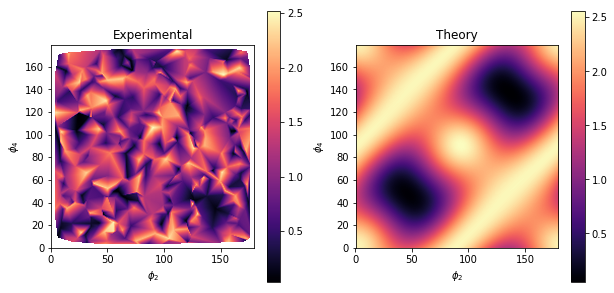

In [9]:
# Load experiment data
filename = 'Aire_linear_todos_2018-10-08.npz'
analyze_angles = False
analyze_results = True
Nxy = 200
f_normalization = np.mean([1.05073474, 1.04197858, 1.04418123, 1.05578199])
data = np.load(filename)
# np.savez(filename+'.npz', angulos = angles, todos = todos, intensidad=I)
angulos = data['angulos']*degrees
param = data['parametros']
Intensity = data['intensidad'] 
#Intensity += [0.0371+0.0192, 4.3301-0.0268]
Intensity = clean_intensity(Intensity, mean[1], Nd=1)
Intensity = Intensity / f_normalization
# Angles
a2 = angulos[:,1]
a3 = angulos[:,2]
a1 = angulos[:,0]
a4 = angulos[:,3]
th1 = np.array([a1, a2, a3, a4])
# Analyze angles distribution
if analyze_angles:
    Nintervals = [4, 4, 4, 4]
    angle_min = -np.array(th0)
    angle_max = np.array([2*pi, 2*pi, 2*pi, 2*pi]) + angle_min
    cuentas = analyze_angles_distribution(th1, Nintervals, angle_min, angle_max, plotfig=True)
    distribution = np.std(cuentas)
    print('Angles random distribution parameter is: {};'.format(distribution))

# Do the polarimeter experiment
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Intensity, th1)

# Calculate target and error
Mtarget = np.identity(4) # Al menos parecido
Mtarget = ps.rotate_mueller(Mtarget, 133.576341506*degrees)
error = Mcalculated - Mtarget
error = np.std(error)

# Plot measurements and theoretical comparation (only valid if P1 and P2 don't move)
if analyze_results:
    # Plot experiment
    plt.figure(figsize=(10, 5))   
    plt.subplot(1,2,1)
    plot_2d_scattered(a2, a3, Intensity, title='Experimental', Nxy=Nxy) 
    # Calculate the theoretical result
    th2, th3 = np.linspace(a2.min(), a2.max(), Nxy), np.linspace(a3.min(), a3.max(), Nxy)
    Mexp = [Jp1, Jr1, Mtarget, Jr2, Jp2]
    th_teory = [0, th2, 0, th3, 0]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)
    # Plot theory 
    plt.subplot(1,2,2)
    plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False)  
    

print('Experiment data:')
print(param)
print('Target')
print(Mtarget)
print('Calculated')
print(Mcalculated)
    
# Filter and calculate again
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.01, verbose=True)
error2 = Mfiltered - Mtarget
error2 = np.std(error2)

# Print result and compare with the theoretical one
print('Filtered')
print(Mfiltered)
print('Error: {}; Error tras filtrar: {};'.format(error, error2))

# Try to extract meaning from the matrix
amm.all_parameters(Mfiltered, tol=0.001)
_, _, _ = amm.decompose_polar(Mfiltered, decomposition='DRP', verbose=True, co=False, tol=0.01, filter=False)
#_, _ = amm.decompose_pure(Mfiltered, right=True, verbose=True, co=False, tol=0.00133)

** Retardador_WQ10E-850-SP 0º (relativo) **

Experiment data:
{'angles origin': [126.94007888766, 184.72733727559998, 2.78054116251, 104.736748578], 'type': 'linear', 'limits': [45, 180, 180, 45]}
Target
[[ 0.87316608  0.0026667  -0.00341322  0.        ]
 [ 0.0026667   0.40941994 -0.36231819 -0.68081436]
 [-0.00341322 -0.36231819  0.59009208 -0.53191047]
 [ 0.          0.68081436  0.53191047  0.12634595]]
Calculated
[[ 0.9489075  -0.00859519 -0.01896712  0.01026497]
 [ 0.01101404  0.94209005  0.00447702  0.07379134]
 [ 0.00880369  0.04856958  0.8127902  -0.49997076]
 [ 0.00448501 -0.06636223  0.4836172   0.79905   ]]
The original matrix is:
[[ 0.9489075  -0.00859519 -0.01896712  0.01026497]
 [ 0.01101404  0.94209005  0.00447702  0.07379134]
 [ 0.00880369  0.04856958  0.8127902  -0.49997076]
 [ 0.00448501 -0.06636223  0.4836172   0.79905   ]]
None condition was violated.
Filtered
[[ 0.9489075  -0.00859519 -0.01896712  0.01026497]
 [ 0.01101404  0.94209005  0.00447702  0.07379134]
 [ 0.00880369  0.04856958  0.8127902  -0.49997076]


d:\codigo\phyton_optics\phyton_optics\utils_common.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  m2[:, ind] = np.squeeze(m[:, ind2])


Sixth condition was violated. Fixed matrix is:
[[ 1.00239166  0.00076419 -0.00054363 -0.        ]
 [-0.00076419  0.99365874  0.00616451  0.        ]
 [ 0.00054363  0.00616451  0.99793894  0.        ]
 [ 0.          0.         -0.          0.9893408 ]]
The original matrix is:
[[ 1.00239166  0.00076419 -0.00054363 -0.        ]
 [-0.00076419  0.99365874  0.00616451  0.        ]
 [ 0.00054363  0.00616451  0.99793894  0.        ]
 [ 0.          0.         -0.          0.9893408 ]]
Zero B condition was violated. Fixed matrix is:
[[ 1.          0.00076237 -0.00054234 -0.        ]
 [-0.00076237  0.99128792  0.0061498   0.        ]
 [ 0.00054234  0.0061498   0.9955579   0.        ]
 [ 0.          0.         -0.          0.98698028]]
The original matrix is:
[[ 1.          0.00076237 -0.00054234 -0.        ]
 [-0.00076237  0.99128792  0.0061498   0.        ]
 [ 0.00054234  0.0061498   0.9955579   0.        ]
 [ 0.          0.         -0.          0.98698028]]
None condition was violated.
Polar de

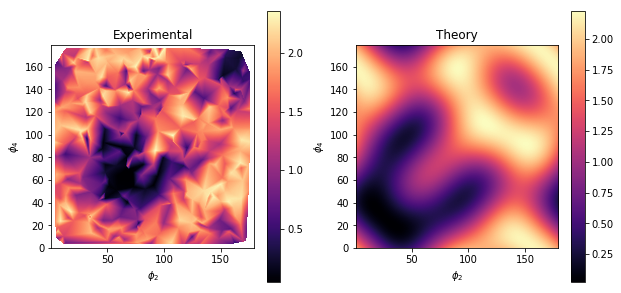

In [16]:
# Load experiment data
filename = 'Retardador_WQ10E-850-SP_30deg_linear_todos_2valpol_2018-10-08.npz'
angle_target = (64)*degrees
Mtarget = Jr2#ps.Mueller_Real_Retarder(0.97, 0.97, 32.5*degrees) # Al menos parecido
analyze_angles = False
analyze_results = True
Nxy = 200
data = np.load(filename)
#f_normalization = 1.06824173
# np.savez(filename+'.npz', angulos = angles, todos = todos, intensidad=I)
angulos = data['angulos']*degrees
param = data['parametros']
Intensity = data['intensidad']
Intensity = clean_intensity(Intensity, mean[1], Nd=1)
Intensity /= f_normalization
# Angles
a2 = angulos[:,1]
a3 = angulos[:,2]
a1 = angulos[:,0]
a4 = angulos[:,3]
th1 = np.array([a1, a2, a3, a4])
# Analyze angles distribution
if analyze_angles:
    Nintervals = [4, 4, 4, 4]
    angle_min = -np.array(th0)
    angle_max = np.array([2*pi, 2*pi, 2*pi, 2*pi]) + angle_min
    cuentas = analyze_angles_distribution(th1, Nintervals, angle_min, angle_max, plotfig=True)
    distribution = np.std(cuentas)
    print('Angles random distribution parameter is: {};'.format(distribution))

# Do the polarimeter experiment
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Intensity, th1)

# Calculate target and error
Mtarget = ps.rotate_mueller(Mtarget, angle_target)
error = Mcalculated - Mtarget
error = np.std(error)

# Plot measurements and theoretical comparation (only valid if P1 and P2 don't move)
if analyze_results:
    # Plot experiment
    plt.figure(figsize=(10, 5))   
    plt.subplot(1,2,1)
    plot_2d_scattered(a2/degrees, a3/degrees, Intensity, title='Experimental', Nxy=Nxy, xy_are_angles=False) 
    # Calculate the theoretical result
    th2, th3 = np.linspace(a2.min(), a2.max(), Nxy), np.linspace(a3.min(), a3.max(), Nxy)
    Mexp = [Jp1, Jr1, Mtarget, Jr2, Jp2]
    th_teory = [0, th2, 0, th3, 0]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)
    # Plot theory 
    plt.subplot(1,2,2)
    plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False)  
    

print('Experiment data:')
print(param)
print('Target')
print(Mtarget)
print('Calculated')
print(Mcalculated)
    
# Filter and calculate again
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.02, verbose=True)
error2 = Mfiltered - Mtarget
error2 = np.std(error2)

# Print result and compare with the theoretical one
print('Filtered')
print(Mfiltered)
print('Error: {}; Error tras filtrar: {};'.format(error, error2))

# Try to extract meaning from the matrix
amm.all_parameters(Mfiltered)
_, _, _ = amm.decompose_polar(Mfiltered, decomposition='DRP', verbose=True, co=False, tol=0.001, filter=False)
_, _ = amm.decompose_pure(Mfiltered, right=True, verbose=True, co=False, tol=0.01)

** Retardador_WQ10E-850-SP 30º (relativo) **

Experiment data:
{'angles origin': [126.94007888766, 184.72733727559998, 2.78054116251, 104.736748578], 'type': 'linear', 'limits': [0, 180, 180, 0]}
Target
[[ 0.9409      0.          0.          0.        ]
 [ 0.          0.44960634 -0.40068933 -0.72290733]
 [ 0.         -0.40068933  0.61410575 -0.58958883]
 [ 0.          0.72290733  0.58958883  0.12281209]]
Calculated
[[ 0.94750721 -0.01559282 -0.01228688  0.01199614]
 [ 0.01298899  0.86726311 -0.07216745 -0.40362609]
 [ 0.01259778 -0.07284177  0.88439161 -0.32316413]
 [ 0.00417224  0.38431463  0.30196228  0.79322693]]
The original matrix is:
[[ 0.94750721 -0.01559282 -0.01228688  0.01199614]
 [ 0.01298899  0.86726311 -0.07216745 -0.40362609]
 [ 0.01259778 -0.07284177  0.88439161 -0.32316413]
 [ 0.00417224  0.38431463  0.30196228  0.79322693]]
None condition was violated.
Filtered
[[ 0.94750721 -0.01559282 -0.01228688  0.01199614]
 [ 0.01298899  0.86726311 -0.07216745 -0.40362609]
 [ 0.01259778 -0.07284177  0.88439161 -0.32316413]
 [

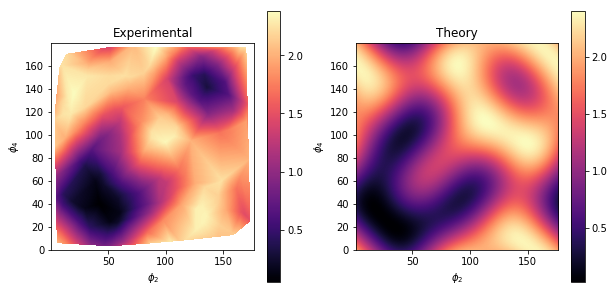

In [24]:
# Load experiment data
filename = 'Retardador_WQ10E-850-SP_30deg_linear_ret_2018-10-04.npz'
angle_target = (64.6)*degrees
Mtarget = ps.Mueller_Real_Retarder(0.97, 0.97, 82.5*degrees) # Al menos parecido
analyze_angles = False
analyze_results = True
Nxy = 200
data = np.load(filename)
f_normalization = 1.06824173
# np.savez(filename+'.npz', angulos = angles, todos = todos, intensidad=I)
angulos = data['angulos']*degrees
param = data['parametros']
Intensity = data['intensidad']
Intensity += [0.0371+0.0192, 4.3301-0.0268]
Intensity = clean_intensity(Intensity, mean[1], Nd=1)
Intensity /= f_normalization
# Angles
a2 = angulos[:,1]
a3 = angulos[:,2]
a1 = angulos[:,0]
a4 = angulos[:,3]
th1 = np.array([a1, a2, a3, a4])
# Analyze angles distribution
if analyze_angles:
    Nintervals = [4, 4, 4, 4]
    angle_min = -np.array(th0)
    angle_max = np.array([2*pi, 2*pi, 2*pi, 2*pi]) + angle_min
    cuentas = analyze_angles_distribution(th1, Nintervals, angle_min, angle_max, plotfig=True)
    distribution = np.std(cuentas)
    print('Angles random distribution parameter is: {};'.format(distribution))

# Do the polarimeter experiment
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Intensity, th1)

# Calculate target and error
Mtarget = ps.rotate_mueller(Mtarget, angle_target)
error = Mcalculated - Mtarget
error = np.std(error)

# Plot measurements and theoretical comparation (only valid if P1 and P2 don't move)
if analyze_results:
    # Plot experiment
    plt.figure(figsize=(10, 5))   
    plt.subplot(1,2,1)
    plot_2d_scattered(a2/degrees, a3/degrees, Intensity, title='Experimental', Nxy=Nxy, xy_are_angles=False) 
    # Calculate the theoretical result
    th2, th3 = np.linspace(a2.min(), a2.max(), Nxy), np.linspace(a3.min(), a3.max(), Nxy)
    Mexp = [Jp1, Jr1, Mtarget, Jr2, Jp2]
    th_teory = [0, th2, 0, th3, 0]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)
    # Plot theory 
    plt.subplot(1,2,2)
    plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False)  
    

print('Experiment data:')
print(param)
print('Target')
print(Mtarget)
print('Calculated')
print(Mcalculated)
    
# Filter and calculate again
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.02, verbose=True)
error2 = Mfiltered - Mtarget
error2 = np.std(error2)

# Print result and compare with the theoretical one
print('Filtered')
print(Mfiltered)
print('Error: {}; Error tras filtrar: {};'.format(error, error2))

# Try to extract meaning from the matrix
amm.all_parameters(Mfiltered)
#_, _, _ = amm.decompose_polar(Mfiltered, decomposition='DRP', verbose=True, co=False, tol=0.001, filter=False)
_, _ = amm.decompose_pure(Mfiltered, right=True, verbose=True, co=False, tol=0.01)

** Polarizador malo 0º **

Experiment data:
{'angles origin': [126.94007888766, 184.72733727559998, 2.78054116251, 104.736748578], 'type': 'linear', 'limits': [0, 180, 180, 0]}
Target
[[0.53125 0.37125 0.      0.     ]
 [0.37125 0.53125 0.      0.     ]
 [0.      0.      0.38    0.     ]
 [0.      0.      0.      0.38   ]]
Calculated
[[ 0.53726215  0.33543534  0.07420422 -0.00502623]
 [ 0.3658244   0.51993228  0.02313997 -0.02404102]
 [ 0.08142704  0.0430177   0.4119546   0.06711666]
 [ 0.00527528  0.01383414 -0.05728234  0.39996458]]
The original matrix is:
[[ 0.53726215  0.33543534  0.07420422 -0.00502623]
 [ 0.3658244   0.51993228  0.02313997 -0.02404102]
 [ 0.08142704  0.0430177   0.4119546   0.06711666]
 [ 0.00527528  0.01383414 -0.05728234  0.39996458]]
None condition was violated.
Filtered
[[ 0.53726215  0.33543534  0.07420422 -0.00502623]
 [ 0.3658244   0.51993228  0.02313997 -0.02404102]
 [ 0.08142704  0.0430177   0.4119546   0.06711666]
 [ 0.00527528  0.01383414 -0.05728234  0.39996458]]
Error: 0.03775

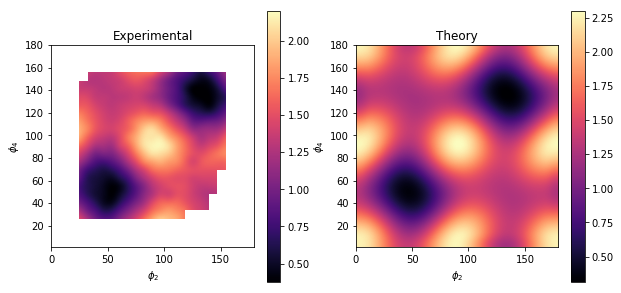

In [63]:
# Load experiment data
filename = 'Polarizador_malo_0deg__linear_ret_2018-10-04.npz'
angle_target = (0)*degrees
Mtarget = ps.polarizer_linear(0.95, 0.4)
analyze_angles = False
analyze_results = True
Nxy = 25
data = np.load(filename)
f_normalization = 1.06824173
# np.savez(filename+'.npz', angulos = angles, todos = todos, intensidad=I)
angulos = data['angulos']*degrees
param = data['parametros']
Intensity = data['intensidad']
Intensity += [0.0371+0.0192, 4.3301-0.0268]
Intensity = clean_intensity(Intensity, mean[1], Nd=1)
Intensity /= f_normalization
# Angles
a2 = angulos[:,1]
a3 = angulos[:,2]
a1 = angulos[:,0]
a4 = angulos[:,3]
th1 = np.array([a1, a2, a3, a4])
# Analyze angles distribution
if analyze_angles:
    Nintervals = [4, 4, 4, 4]
    angle_min = -np.array(th0)
    angle_max = np.array([2*pi, 2*pi, 2*pi, 2*pi]) + angle_min
    cuentas = analyze_angles_distribution(th1, Nintervals, angle_min, angle_max, plotfig=True)
    distribution = np.std(cuentas)
    print('Angles random distribution parameter is: {};'.format(distribution))

# Do the polarimeter experiment
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Intensity, th1)

# Calculate target and error
Mtarget = ps.rotate_mueller(Mtarget, angle_target)
error = Mcalculated - Mtarget
error = np.std(error)

# Plot measurements and theoretical comparation (only valid if P1 and P2 don't move)
if analyze_results:
    # Plot experiment
    plt.figure(figsize=(10, 5))   
    plt.subplot(1,2,1)
    plot_2d_scattered(a2/degrees, a3/degrees, Intensity, title='Experimental', Nxy=Nxy, xy_are_angles=False) 
    # Calculate the theoretical result
    th2, th3 = np.linspace(a2.min(), a2.max(), Nxy), np.linspace(a3.min(), a3.max(), Nxy)
    Mexp = [Jp1, Jr1, Mtarget, Jr2, Jp2]
    th_teory = [0, th2, 0, th3, 0]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)
    # Plot theory 
    plt.subplot(1,2,2)
    plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False)  
    

print('Experiment data:')
print(param)
print('Target')
print(Mtarget)
print('Calculated')
print(Mcalculated)
    
# Filter and calculate again
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.01, verbose=True)
error2 = Mfiltered - Mtarget
error2 = np.std(error2)

# Print result and compare with the theoretical one
print('Filtered')
print(Mfiltered)
print('Error: {}; Error tras filtrar: {};'.format(error, error2))

# Try to extract meaning from the matrix
amm.all_parameters(Mfiltered)
_, _, _ = amm.decompose_polar(Mfiltered, decomposition='DRP', verbose=True, co=False, tol=0.001, filter=False)
_, _ = amm.decompose_pure(Mfiltered, right=True, verbose=True, co=False, tol=0.01)

** Papel **

Experiment data:
{'angles origin': [126.94007888766, 184.72733727559998, 2.78054116251, 104.736748578], 'type': 'linear', 'limits': [0, 180, 180, 0]}
Target
[[1.  0.  0.  0. ]
 [0.  0.8 0.  0. ]
 [0.  0.  0.8 0. ]
 [0.  0.  0.  0.8]]
Calculated
[[ 1.90669553 -0.0071168  -0.01186491  0.00625976]
 [-0.00233099  0.00173018  0.00389123 -0.00424106]
 [-0.00393226 -0.00080823 -0.00127223 -0.00566986]
 [-0.00215424  0.00291017  0.00737457 -0.00112808]]
The original matrix is:
[[ 1.90669553 -0.0071168  -0.01186491  0.00625976]
 [-0.00233099  0.00173018  0.00389123 -0.00424106]
 [-0.00393226 -0.00080823 -0.00127223 -0.00566986]
 [-0.00215424  0.00291017  0.00737457 -0.00112808]]
Zero B condition was violated. Fixed matrix is:
[[ 1.         -0.00373253 -0.00622276  0.00328304]
 [-0.00122253  0.00090742  0.00204082 -0.0022243 ]
 [-0.00206234 -0.00042389 -0.00066725 -0.00297366]
 [-0.00112983  0.00152629  0.00386773 -0.00059164]]
The original matrix is:
[[ 1.         -0.00373253 -0.00622276  0.003

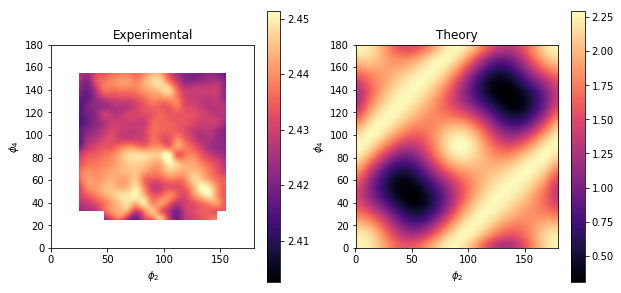

In [64]:
# Load experiment data
filename = 'Papel_linear_ret_2018-10-04.npz'
angle_target = (0)*degrees
Mtarget = np.diag([1, 0.8, 0.8, 0.8])
analyze_angles = False
analyze_results = True
Nxy = 25
data = np.load(filename)
f_normalization = 1.06824173
# np.savez(filename+'.npz', angulos = angles, todos = todos, intensidad=I)
angulos = data['angulos']*degrees
param = data['parametros']
Intensity = data['intensidad']
Intensity += [0.0371+0.0192, 4.3301-0.0268]
Intensity = clean_intensity(Intensity, mean[1], Nd=1)
Intensity /= f_normalization
# Angles
a2 = angulos[:,1]
a3 = angulos[:,2]
a1 = angulos[:,0]
a4 = angulos[:,3]
th1 = np.array([a1, a2, a3, a4])
# Analyze angles distribution
if analyze_angles:
    Nintervals = [4, 4, 4, 4]
    angle_min = -np.array(th0)
    angle_max = np.array([2*pi, 2*pi, 2*pi, 2*pi]) + angle_min
    cuentas = analyze_angles_distribution(th1, Nintervals, angle_min, angle_max, plotfig=True)
    distribution = np.std(cuentas)
    print('Angles random distribution parameter is: {};'.format(distribution))

# Do the polarimeter experiment
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Intensity, th1)

# Calculate target and error
Mtarget = ps.rotate_mueller(Mtarget, angle_target)
error = Mcalculated - Mtarget
error = np.std(error)

# Plot measurements and theoretical comparation (only valid if P1 and P2 don't move)
if analyze_results:
    # Plot experiment
    plt.figure(figsize=(10, 5))   
    plt.subplot(1,2,1)
    plot_2d_scattered(a2/degrees, a3/degrees, Intensity, title='Experimental', Nxy=Nxy, xy_are_angles=False) 
    # Calculate the theoretical result
    th2, th3 = np.linspace(a2.min(), a2.max(), Nxy), np.linspace(a3.min(), a3.max(), Nxy)
    Mexp = [Jp1, Jr1, Mtarget, Jr2, Jp2]
    th_teory = [0, th2, 0, th3, 0]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)
    # Plot theory 
    plt.subplot(1,2,2)
    plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False)  
    

print('Experiment data:')
print(param)
print('Target')
print(Mtarget)
print('Calculated')
print(Mcalculated)
    
# Filter and calculate again
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.01, verbose=True)
error2 = Mfiltered - Mtarget
error2 = np.std(error2)

# Print result and compare with the theoretical one
print('Filtered')
print(Mfiltered)
print('Error: {}; Error tras filtrar: {};'.format(error, error2))

# Try to extract meaning from the matrix
amm.all_parameters(Mfiltered)
_, _, _ = amm.decompose_polar(Mfiltered, decomposition='DRP', verbose=True, co=False, tol=0.001, filter=False)
_, _ = amm.decompose_pure(Mfiltered, right=True, verbose=True, co=False, tol=0.01)

** Difusor **

Experiment data:
{'angles origin': [126.94007888766, 184.72733727559998, 2.78054116251, 104.736748578], 'type': 'linear', 'limits': [0, 180, 180, 0]}
Target
[[1.  0.  0.  0. ]
 [0.  0.8 0.  0. ]
 [0.  0.  0.8 0. ]
 [0.  0.  0.  0.8]]
Calculated
[[ 0.27504406 -0.0044697  -0.00384951  0.00188878]
 [ 0.00683365  0.27210734  0.00221528 -0.00714431]
 [-0.00006654  0.00305261  0.27156486 -0.00167772]
 [ 0.00194471 -0.00042254  0.00230338  0.27356033]]
The original matrix is:
[[ 0.27504406 -0.0044697  -0.00384951  0.00188878]
 [ 0.00683365  0.27210734  0.00221528 -0.00714431]
 [-0.00006654  0.00305261  0.27156486 -0.00167772]
 [ 0.00194471 -0.00042254  0.00230338  0.27356033]]
None condition was violated.
Filtered
[[ 0.27504406 -0.0044697  -0.00384951  0.00188878]
 [ 0.00683365  0.27210734  0.00221528 -0.00714431]
 [-0.00006654  0.00305261  0.27156486 -0.00167772]
 [ 0.00194471 -0.00042254  0.00230338  0.27356033]]
Error: 0.253488510407; Error tras filtrar: 0.253488510407;
 
Parameters of the

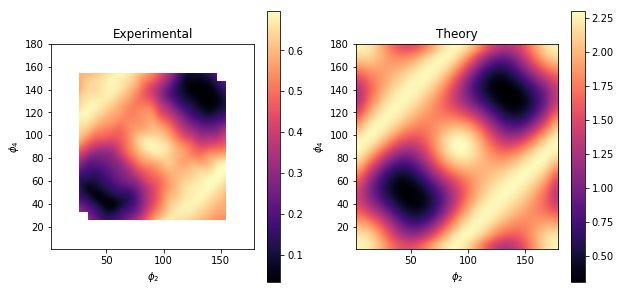

In [65]:
# Load experiment data
filename = 'Difusor_DG10-600B_0deg_linear_ret_2018-10-04.npz'
angle_target = (0)*degrees
Mtarget = np.diag([1, 0.8, 0.8, 0.8])
analyze_angles = False
analyze_results = True
Nxy = 25
data = np.load(filename)
f_normalization = 1.06824173
# np.savez(filename+'.npz', angulos = angles, todos = todos, intensidad=I)
angulos = data['angulos']*degrees
param = data['parametros']
Intensity = data['intensidad']
Intensity += [0.0371+0.0192, 4.3301-0.0268]
Intensity = clean_intensity(Intensity, mean[1], Nd=1)
Intensity /= f_normalization
# Angles
a2 = angulos[:,1]
a3 = angulos[:,2]
a1 = angulos[:,0]
a4 = angulos[:,3]
th1 = np.array([a1, a2, a3, a4])
# Analyze angles distribution
if analyze_angles:
    Nintervals = [4, 4, 4, 4]
    angle_min = -np.array(th0)
    angle_max = np.array([2*pi, 2*pi, 2*pi, 2*pi]) + angle_min
    cuentas = analyze_angles_distribution(th1, Nintervals, angle_min, angle_max, plotfig=True)
    distribution = np.std(cuentas)
    print('Angles random distribution parameter is: {};'.format(distribution))

# Do the polarimeter experiment
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Intensity, th1)

# Calculate target and error
Mtarget = ps.rotate_mueller(Mtarget, angle_target)
error = Mcalculated - Mtarget
error = np.std(error)

# Plot measurements and theoretical comparation (only valid if P1 and P2 don't move)
if analyze_results:
    # Plot experiment
    plt.figure(figsize=(10, 5))   
    plt.subplot(1,2,1)
    plot_2d_scattered(a2/degrees, a3/degrees, Intensity, title='Experimental', Nxy=Nxy, xy_are_angles=False) 
    # Calculate the theoretical result
    th2, th3 = np.linspace(a2.min(), a2.max(), Nxy), np.linspace(a3.min(), a3.max(), Nxy)
    Mexp = [Jp1, Jr1, Mtarget, Jr2, Jp2]
    th_teory = [0, th2, 0, th3, 0]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)
    # Plot theory 
    plt.subplot(1,2,2)
    plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False)  
    

print('Experiment data:')
print(param)
print('Target')
print(Mtarget)
print('Calculated')
print(Mcalculated)
    
# Filter and calculate again
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.01, verbose=True)
error2 = Mfiltered - Mtarget
error2 = np.std(error2)

# Print result and compare with the theoretical one
print('Filtered')
print(Mfiltered)
print('Error: {}; Error tras filtrar: {};'.format(error, error2))

# Try to extract meaning from the matrix
amm.all_parameters(Mfiltered)
_, _, _ = amm.decompose_polar(Mfiltered, decomposition='DRP', verbose=True, co=False, tol=0.001, filter=False)
_, _ = amm.decompose_pure(Mfiltered, right=True, verbose=True, co=False, tol=0.01)